# загрузка датасетов


In [ ]:
# все исправленные датасеты лежать по ссылке https://disk.yandex.ru/d/mEak3w2wbQO3Aw. 
# Для данного ноутбука нужны архивы train_head.zip и train_human.zip

In [ ]:
!unzip train_head.zip
!mv train train_head
!rm labelmap.txt

In [ ]:
!unzip train_human.zip
!mv train train_human
!rm labelmap.txt

# Импорт библиотек

In [11]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -r ./yolov5/requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 13306, done.
remote: Counting objects: 100% (304/304), done.
remote: Compressing objects: 100% (163/163), done.
remote: Total 13306 (delta 176), reused 253 (delta 141), pack-reused 13002
Receiving objects: 100% (13306/13306), 12.80 MiB | 30.61 MiB/s, done.
Resolving deltas: 100% (9086/9086), done.


In [2]:
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
import math
from PIL import Image
import numpy as np
import shutil
import yaml
from shapely.geometry import Polygon
from sklearn.model_selection import train_test_split
import matplotlib.patches as patches
import albumentations

# Слияние двух датасетов

In [ ]:
!rm -r ./train

!mkdir ./train
!mkdir ./train/images
!mkdir ./train/labels

In [7]:
def reoder_files(human_path, head_path, dest_path):
    processed = set()
    bboxes = dict()

    for name in os.listdir(human_path + '/images'):
        txt_name = name.split('.')[0] + '.txt'
        bboxes[txt_name] = []
        for line in open(human_path + '/labels/' + txt_name).readlines():
            coords = line.split()
            bboxes[txt_name].append('0 ' + ' '.join(coords[1:]))

        shutil.copy(human_path + '/images/' + name, dest_path + '/' + 'images')
        processed.add(name)

    for name in os.listdir(head_path + '/images'):
        txt_name = name.split('.')[0] + '.txt'
        if txt_name not in bboxes.keys():
            bboxes[txt_name] = []

        for line in open(head_path + '/labels/' + txt_name).readlines():
            coords = line.split()
            bboxes[txt_name].append('1 ' + ' '.join(coords[1:]))

        if name not in processed:
            shutil.copy(head_path + '/images/' + name, dest_path + '/' + 'images')
            processed.add(name)
    
    for name in bboxes.keys():
        with open(dest_path + '/labels/' + name, 'w') as f:
            for b in bboxes[name]:
                f.write(b + '\n')

reoder_files('/content/train_human', '/content/train_head', './train')

# Разделение на обучающую и валидационную выборки

In [30]:
!rm -r ./train_split
!rm -r ./val_split

!mkdir ./train_split/
!mkdir ./train_split/images
!mkdir ./train_split/labels
!mkdir ./val_split
!mkdir ./val_split/images
!mkdir ./val_split/labels

In [31]:
train_path = './train_split/'
val_path = './val_split/'
source_path = './train/'

names = [s.split('.')[0] for s in os.listdir('./train/images')]
train_names, val_names = train_test_split(names, test_size=0.3, random_state=42, shuffle=True)
print(len(train_names), len(val_names))

for name in train_names:
  shutil.copy(os.path.join(os.path.join(source_path, 'images'), f'{name}.jpg'), os.path.join(train_path, 'images'))
  shutil.copy(os.path.join(os.path.join(source_path, 'labels'), f'{name}.txt'), os.path.join(train_path, 'labels'))

for name in val_names:
  shutil.copy(os.path.join(os.path.join(source_path, 'images'), f'{name}.jpg'), os.path.join(val_path, 'images'))
  shutil.copy(os.path.join(os.path.join(source_path, 'labels'), f'{name}.txt'), os.path.join(val_path, 'labels'))


print(len(os.listdir(train_path + 'images')), len(os.listdir(val_path + 'images')))

1653 88
1653 88


(1080, 1920, 3)
[[0.         0.00975521 0.07806019 0.01226042 0.04991667]
 [0.         0.03229167 0.12503241 0.01145833 0.07080556]
 [0.         0.76014844 0.36198611 0.03006771 0.09330556]
 [0.         0.34694792 0.25925926 0.03228125 0.11905556]
 [0.         0.01990365 0.13348611 0.01199479 0.05202778]
 [0.         0.02834115 0.08719907 0.01015104 0.05741667]
 [0.         0.47897135 0.28258333 0.02845312 0.13072222]
 [1.         0.35604687 0.21150926 0.0125     0.0242963 ]
 [1.         0.77152604 0.32223148 0.00701042 0.0132963 ]
 [1.         0.0292526  0.06369907 0.00420313 0.00837963]
 [1.         0.02117708 0.11275    0.00521875 0.01137037]
 [1.         0.4844974  0.23243981 0.01168229 0.02637963]
 [1.         0.05819792 0.11394907 0.00829167 0.01702778]
 [1.         0.01116667 0.05891204 0.00571875 0.01076852]
 [1.         0.03488802 0.09345833 0.00538021 0.01106481]]


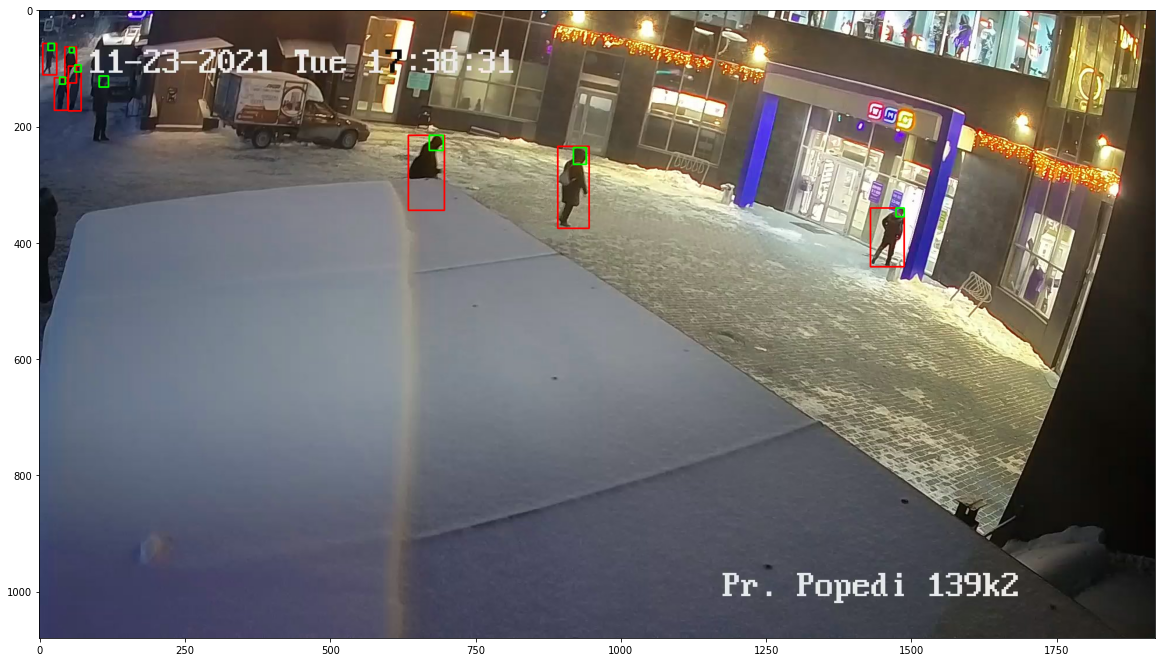

In [32]:
img_name = '23-11-2021_02-38-32_PM'
img = cv2.imread(f'./train_split/images/{img_name}.jpg')
ndf = pd.read_csv(f'./train_split/labels/{img_name}.txt', sep=' ', names=['class', 'x', 'y', 'w', 'h'])
data = ndf.to_numpy()
print(img.shape)
if list(ndf.index).count(img_name) == 1:
  data = np.expand_dims(data, axis=0)
print(data)

dh, dw, _ = img.shape

for p in range(len(data)):
    cls = int(data[p][0])
    x, y, w, h = float(data[p][1]), float(data[p][2]), float(data[p][3]), float(data[p][4])

    l = int((x - w / 2) * dw)
    r = int((x + w / 2) * dw)
    t = int((y - h / 2) * dh)
    b = int((y + h / 2) * dh)

    if l < 0:
        l = 0
    if r > dw - 1:
        r = dw - 1
    if t < 0:
        t = 0
    if b > dh - 1:
        b = dh - 1

    if cls == 0:
      cv2.rectangle(img, (l, t), (r, b), (255, 0, 0), 2)
    else:
      cv2.rectangle(img, (l, t), (r, b), (0, 255, 0), 2)

plt.figure(figsize=(20, 30))
plt.imshow(img)

# Создание data.yaml и объявление конфигурации модели

In [39]:
#обучение на всем датасете

num_classes = 2
#в папке data_for_yolo создадим dataset.yaml со следующим содержимым

yaml_content = f"""
train: /content/train_split/images
val: /content/val_split/images

# number of classes
nc: {num_classes}

# class names
names: ['human', 'head']
"""

names = yaml.safe_load(yaml_content)

with open('./data.yaml', 'w') as file:
    yaml.dump(names, file)

In [33]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [34]:
!cat ./yolov5/models/yolov5m.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.67  # model depth multiple
width_multiple: 0.75  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [35]:
%%writetemplate ./yolov5/models/custom_yolov5m.yaml
# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.67  # model depth multiple
width_multiple: 0.75  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [36]:
%%writetemplate ./yolov5/data/hyps/hyp.scratch-low.yaml


# YOLOv5 🚀 by Ultralytics, GPL-3.0 license
# Hyperparameters for low-augmentation COCO training from scratch
# python train.py --batch 64 --cfg yolov5n6.yaml --weights '' --data coco.yaml --img 640 --epochs 300 --linear
# See tutorials for hyperparameter evolution https://github.com/ultralytics/yolov5#tutorials

lr0: 0.005  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.01  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.5  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 1.0  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
hsv_h: 0.015  # image HSV-Hue augmentation (fraction)
hsv_s: 0.7  # image HSV-Saturation augmentation (fraction)
hsv_v: 0.4  # image HSV-Value augmentation (fraction)
degrees: 0.0  # image rotation (+/- deg)
translate: 0.1  # image translation (+/- fraction)
scale: 0.5  # image scale (+/- gain)
shear: 0.0  # image shear (+/- deg)
perspective: 0.0  # image perspective (+/- fraction), range 0-0.001
flipud: 0.0  # image flip up-down (probability)
fliplr: 0.5  # image flip left-right (probability)
mosaic: 1.0  # image mosaic (probability)
mixup: 0.0  # image mixup (probability)
copy_paste: 0.0  # segment copy-paste (probability)

# Обучение

In [40]:
# train yolov5s on custom data for 100 epochs
# time its performance
!python /content/yolov5/train.py --img 1000 --batch 16 --epochs 50 --data /content/data.yaml --cfg /content/yolov5/models/custom_yolov5m.yaml --weights yolov5m.pt --name yolov5m_results  --cache

train: weights=yolov5m.pt, cfg=/content/yolov5/models/custom_yolov5m.yaml, data=/content/data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=1000, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=yolov5m_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/ultralytics/yolov5
   8fd337b..56f8ef7  update/ci  -> origin/update/ci
github: ⚠️ YOLOv

# Инференс

In [43]:
!wget test.zip https://lodmedia.hb.bizmrg.com/case_files/789899/test_dataset_test.zip

--2022-08-18 21:12:29--  http://test.zip/
Resolving test.zip (test.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘test.zip’
--2022-08-18 21:12:29--  https://lodmedia.hb.bizmrg.com/case_files/789899/test_dataset_test.zip
Resolving lodmedia.hb.bizmrg.com (lodmedia.hb.bizmrg.com)... 217.69.142.100
Connecting to lodmedia.hb.bizmrg.com (lodmedia.hb.bizmrg.com)|217.69.142.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 455731722 (435M) [application/zip]
Saving to: ‘test_dataset_test.zip’

test_dataset_test.z 100%[===================>] 434.62M  21.6MB/s    in 21s     

2022-08-18 21:12:51 (20.3 MB/s) - ‘test_dataset_test.zip’ saved [455731722/455731722]

FINISHED --2022-08-18 21:12:51--
Total wall clock time: 22s
Downloaded: 1 files, 435M in 21s (20.3 MB/s)


In [ ]:
!unzip test_dataset_test.zip

In [47]:
len(os.listdir('test/images'))

855

In [57]:
!python3 yolov5/detect.py --weights /content/yolov5/runs/train/yolov5m_results/weights/best.pt --img 1000 --conf 0.6 --source /content/test/images --save-txt --save-conf

detect: weights=['/content/yolov5/runs/train/yolov5m_results7/weights/best.pt'], source=/content/test/images, data=yolov5/data/coco128.yaml, imgsz=[1000, 1000], conf_thres=0.6, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.2-13-gc0e7a77 Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5m summary: 290 layers, 20856975 parameters, 0 gradients, 47.9 GFLOPs
image 1/855 /content/test/images/0_23-11-2021_02-18-50_PM.jpg: 672x1024 Done. (0.043s)
image 2/855 /content/test/images/0_23-11-2021_02-18-56_PM.jpg: 864x1024 Done. (0.044s)
image 3/855 /content/test/images/0_23-11-2021_02-19-19_PM.jpg: 640x1024 Done. (0.025s)
image 4/855 /content/test/images/0_23-11-2021_0

In [58]:
def get_soliton_labels_df_simple_solution(path_to_txt_folder):
  simple_solution = []
  for detection_file in os.listdir(path_to_txt_folder):
    img_name = detection_file.split('.')[0] + '.jpg'
    with open(path_to_txt_folder + detection_file, 'r') as f:
      data = f.read()
      data = [i for i in data.split('\n') if i != '']
    for line in data:
      val = [float(i) for i in line.split()]
      cls, xywh, conf = val[0], val[1:5], val[5]
      center_x, center_y, width, height = xywh
      xmin = center_x - (width / 2)
      xmax = center_x + (width / 2)
      ymin = center_y - (height / 2)
      ymax = center_y + (height / 2)

      if cls == 0:
        simple_solution.append([img_name, 3, conf, xmin, xmax, ymin, ymax])
      else:
        simple_solution.append([img_name, 1, conf, xmin, xmax, ymin, ymax])
  return simple_solution

In [59]:
simple_solution = get_soliton_labels_df_simple_solution('yolov5/runs/detect/exp/labels/')
simple_solution = pd.DataFrame(simple_solution, columns=['ImageID', 'LabelName', 'Conf', 'XMin', 'XMax', 'YMin', 'YMax'])

In [60]:
simple_solution

,ImageID,LabelName,Conf,XMin,XMax,YMin,YMax
0,25-11-2021_03-59-16_PM.jpg,1,0.410526,0.069196,0.073661,0.189474,0.197368
1,25-11-2021_03-59-16_PM.jpg,1,0.461183,0.060640,0.065104,0.188816,0.196710
2,25-11-2021_03-59-16_PM.jpg,3,0.695883,0.058408,0.066592,0.188816,0.236184
3,25-11-2021_03-59-16_PM.jpg,3,0.758382,0.068080,0.076637,0.189474,0.235526
4,24-11-2021_05-29-37_AM.jpg,1,0.821002,0.042188,0.051042,0.253704,0.270370
...,...,...,...,...,...,...,...
3825,25-11-2021_06-10-20_AM.jpg,3,0.928510,0.866815,0.885417,0.336184,0.438158
3826,25-11-2021_01-54-21_PM.jpg,1,0.837945,0.115625,0.129167,0.393518,0.419444
3827,25-11-2021_01-54-21_PM.jpg,3,0.916435,0.107292,0.132812,0.398149,0.533334
3828,25-11-2021_10-01-52_AM.jpg,1,0.893589,0.836979,0.859375,0.026852,0.071296


In [61]:
simple_solution.to_csv("human_and_head.csv", sep=';', index=False)

In [62]:
simple_solution

,ImageID,LabelName,Conf,XMin,XMax,YMin,YMax
0,25-11-2021_03-59-16_PM.jpg,1,0.410526,0.069196,0.073661,0.189474,0.197368
1,25-11-2021_03-59-16_PM.jpg,1,0.461183,0.060640,0.065104,0.188816,0.196710
2,25-11-2021_03-59-16_PM.jpg,3,0.695883,0.058408,0.066592,0.188816,0.236184
3,25-11-2021_03-59-16_PM.jpg,3,0.758382,0.068080,0.076637,0.189474,0.235526
4,24-11-2021_05-29-37_AM.jpg,1,0.821002,0.042188,0.051042,0.253704,0.270370
...,...,...,...,...,...,...,...
3825,25-11-2021_06-10-20_AM.jpg,3,0.928510,0.866815,0.885417,0.336184,0.438158
3826,25-11-2021_01-54-21_PM.jpg,1,0.837945,0.115625,0.129167,0.393518,0.419444
3827,25-11-2021_01-54-21_PM.jpg,3,0.916435,0.107292,0.132812,0.398149,0.533334
3828,25-11-2021_10-01-52_AM.jpg,1,0.893589,0.836979,0.859375,0.026852,0.071296


# Отображение предсказаний

(1520, 2688, 3)
[['3' '0.41018' '0.1119795' '0.1279765' '0.2697369' '0.3434211']
 ['3' '0.49576' '0.49739599999999995' '0.627232' '0.7717105'
  '0.9999994999999999']
 ['1' '0.547287' '0.5584079' '0.6238840999999999' '0.7717105'
  '0.8749994999999999']
 ['1' '0.815993' '0.9118305' '0.9274555' '0.3638153'
  '0.39276269999999996']
 ['1' '0.853085' '0.45833315' '0.48549085' '0.41907845'
  '0.47499955000000005']
 ['3' '0.939976' '0.8787202500000001' '0.93266375' '0.3638155'
  '0.5592105']
 ['3' '0.954366' '0.44382455' '0.51971745' '0.42105250000000005'
  '0.7013155']]


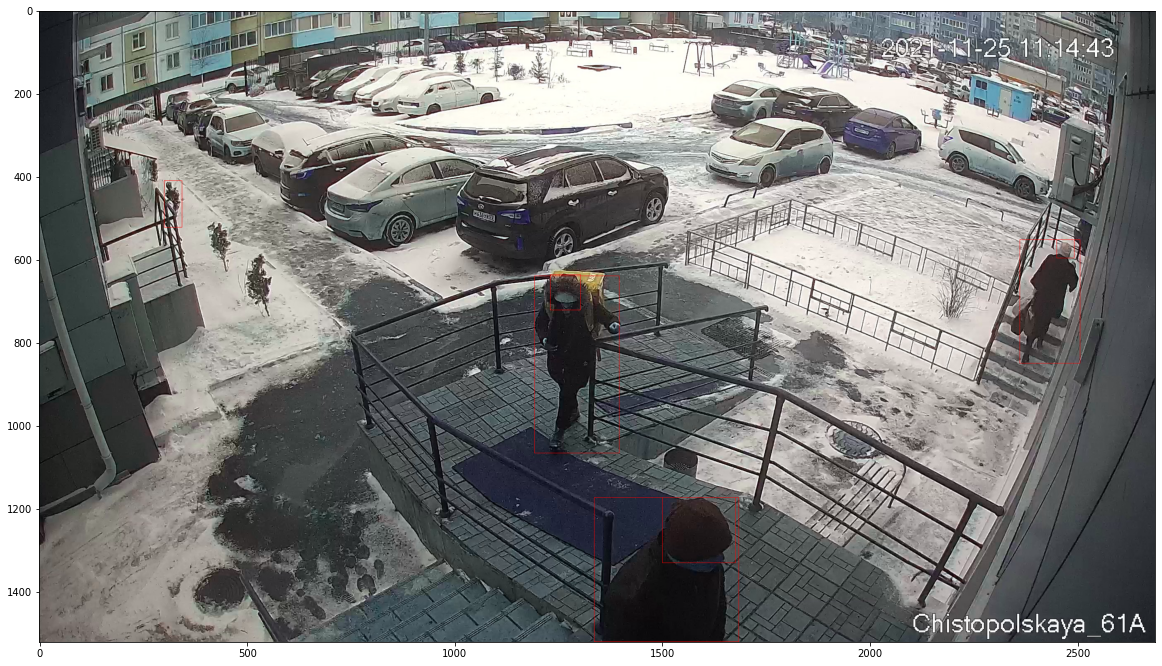

In [63]:
img_name = '25-11-2021_08-14-45_AM.jpg'
img = cv2.imread(f'./test/images/{img_name}')
ndf = pd.read_csv('human_and_head_sol.csv', sep=';', names=['class', 'conf', 'x', 'y', 'w', 'h'])
data = ndf.loc[img_name].to_numpy()
print(img.shape)
if list(ndf.index).count(img_name) == 1:
  data = np.expand_dims(data, axis=0)
print(data)

dh, dw, _ = img.shape

for p in range(len(data)):
    x, y, w, h = float(data[p][2]), float(data[p][3]), float(data[p][4]), float(data[p][5])

    l = int(x * dw)
    r = int(y * dw)
    t = int(w * dh)
    b = int(h * dh)

    if l < 0:
        l = 0
    if r > dw - 1:
        r = dw - 1
    if t < 0:
        t = 0
    if b > dh - 1:
        b = dh - 1

    cv2.rectangle(img, (l, t), (r, b), (255, 0, 0), 2)

plt.figure(figsize=(20, 30))
plt.imshow(img)